In [2]:
# !pip install ipywidgets --quiet
# !pip install --upgrade sagemaker

In [4]:
# !pip install --upgrade ipywidgets

In [5]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [30]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, payload, content_type, accept):
    """Query the model predictor."""

    query_response = model_predictor.predict(
        payload,
        {
            "ContentType": content_type,
            "Accept": accept,
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return the generated images."""

    response_dict = json.loads(query_response)
    return response_dict["generated_images"]


def display_img_and_prompt(img, prmpt):
    """Display the generated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

# Deploy stable diffusion inpainting model

In [31]:
# from ipywidgets import Dropdown
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models

# Retrieves all Text-to-Image generation models.
filter_value = "task == inpainting"
inpainting_models = list_jumpstart_models(filter=filter_value)

# display the model-ids in a dropdown to select a model for inference.
inpainting_models

['model-inpainting-runwayml-stable-diffusion-inpainting',
 'model-inpainting-runwayml-stable-diffusion-inpainting-fp16',
 'model-inpainting-stabilityai-stable-diffusion-2-inpainting',
 'model-inpainting-stabilityai-stable-diffusion-2-inpainting-fp16',
 'model-inpainting-stabilityai-stable-diffusion2-inpainting-fp16']

In [35]:
# model_id, model_version = "model-inpainting-stabilityai-stable-diffusion-2-inpainting", "*"
model_id, model_version = "model-inpainting-stabilityai-stable-diffusion-2-inpainting", "1.*"

In [36]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(f"jumpstart-example-{model_id}")

# Instances with more GPU memory supports generation of larger images.
# So, please select instance types such as ml.g5.2xlarge if you want to generate a very large image.
inference_instance_type = "ml.g5.2xlarge"

# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the model uri. This includes the pre-trained model and parameters as well as the inference scripts.
# This includes all dependencies and scripts for model loading, inference handling etc..
model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)

# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    model_data=model_uri,
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
)

Using model 'model-inpainting-stabilityai-stable-diffusion-2-inpainting' with version '1.1.0'. You can upgrade to version '2.0.1' to get the latest model specifications. Note that models may have different input/output signatures after a major version upgrade.
INFO:sagemaker.jumpstart:Using model 'model-inpainting-stabilityai-stable-diffusion-2-inpainting' with version '1.1.0'. You can upgrade to version '2.0.1' to get the latest model specifications. Note that models may have different input/output signatures after a major version upgrade.
Using model 'model-inpainting-stabilityai-stable-diffusion-2-inpainting' with wildcard version identifier '1.*'. You can pin to version '1.1.0' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


In [37]:
# deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

INFO:sagemaker:Creating model with name: jumpstart-example-model-inpainting-stab-2024-10-29-11-16-22-063


INFO:sagemaker:Creating endpoint-config with name jumpstart-example-model-inpainting-stab-2024-10-29-11-16-22-063
INFO:sagemaker:Creating endpoint with name jumpstart-example-model-inpainting-stab-2024-10-29-11-16-22-063


----------!

In [38]:
import io
from PIL import Image, ImageDraw, ImageFilter

rekognition = boto3.client('rekognition')

# masking

In [39]:
# 이미지 경로 설정
painter_image_path = "input_image/painter.jpeg"
my_face_image_path = "input_image/gonsoo_fall.jpg"


In [40]:
from PIL import Image, ImageDraw
import io
# with open("./source.png", 'rb') as image_file:
#     image_bytes = image_file.read()

with open(painter_image_path, 'rb') as image_file:
    image_bytes = image_file.read()

    
# 원본 이미지 열기
image = Image.open(io.BytesIO(image_bytes))
width, height = image.size

# 마스크 생성 (초기값: 약간의 블러)
mask = Image.new(mode="RGB", size=(width, height), color=(255,255,255))  # 배경을 약간 흐리게 하기 위해 220으로 설정
draw = ImageDraw.Draw(mask)

# Rekognition으로 얼굴 감지
response = rekognition.detect_faces(
    Image={'Bytes': image_bytes},
    Attributes=['DEFAULT']
)

# 각 얼굴에 대해 처리
for face_detail in response['FaceDetails']:
    bbox = face_detail['BoundingBox']

    # 바운딩 박스 좌표 계산
    left = int(bbox['Left'] * width)
    top = int(bbox['Top'] * height)
    right = int((bbox['Left'] + bbox['Width']) * width)
    bottom = int((bbox['Top'] + bbox['Height']) * height)

    # 얼굴 영역을 검은색으로 채우기
    # 패딩을 추가하여 얼굴 주변을 더 자연스럽게 처리
    padding = int(min(bbox['Width'], bbox['Height']) * width * 0.1)
    draw.rectangle([
        left - padding,
        top - padding,
        right + padding,
        bottom + padding
    ], fill=(0, 0, 0))

# 전체 마스크에 블러 효과 적용
mask = mask.filter(ImageFilter.GaussianBlur(radius=2))
    
mask.save("mask.png", format="PNG")

# inpainting

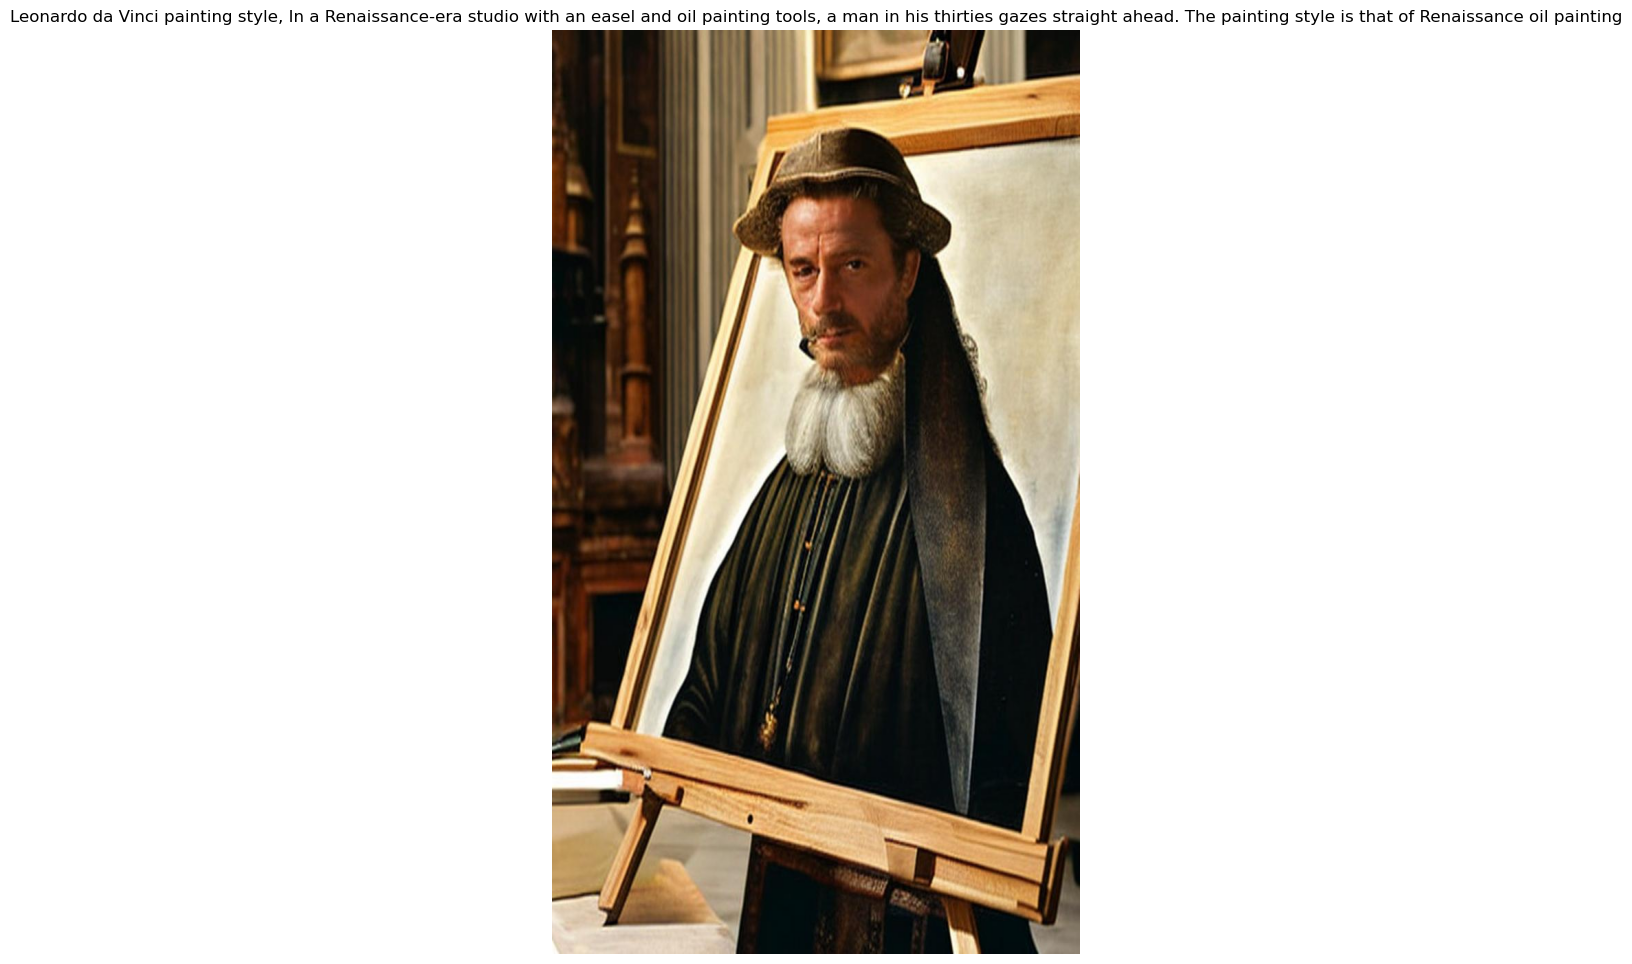

In [41]:
import base64
from PIL import Image
from io import BytesIO
import random


# content_type = 'application/json;jpeg', endpoint expects payload to be a json with the original image and the mask image as bytes encoded with base64.b64 encoding.
# To send raw image to the endpoint, you can set content_type = 'application/json' and encoded_image as np.array(PIL.Image.open(input_img_file_name.jpg)).tolist()
content_type = "application/json;jpeg"


with open(painter_image_path, "rb") as f:
    input_img_image_bytes = f.read()
with open("./mask.png", "rb") as f:
    input_img_mask_image_bytes = f.read()

encoded_input_image = base64.b64encode(bytearray(input_img_image_bytes)).decode()
encoded_mask = base64.b64encode(bytearray(input_img_mask_image_bytes)).decode()

prompt = "Leonardo da Vinci painting style, In a Renaissance-era studio with an easel and oil painting tools, a man in his thirties gazes straight ahead. The painting style is that of Renaissance oil painting"

payload = {
    "prompt": prompt,
    "image": encoded_input_image,
    "mask_image": encoded_mask,
    "num_inference_steps": 50,
    "guidance_scale": 12,
    "seed": random.randint(0, 10000),
    "negative_prompt": "(deformed, distorted, disfigured), bad anatomy, bad proportions, extra limbs, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, mutated, blurry, ugly, oversaturated, grain, low-res, Deformed, bad anatomy, disfigured, poorly drawn face, mutated, extra limb, ugly, poorly drawn hands, missing limb, floating limbs, disconnected limbs, malformed hands, blur, out of focus, long neck, long body, plastic, 3d render, (((duplicate))), ((morbid)), ((mutilated)), extra fingers, mutated hands, ((poorly drawn hands)), ((poorly drawn face)), (((mutation))), (((deformed))), ((ugly)), blurry, ((bad anatomy)), (((bad proportions))), ((extra limbs)), cloned face, glitchy, out of frame, gross proportions, (malformed limbs), ((missing arms)), ((missing legs)), (((extra arms))), (((extra legs))), mutated hands, (fused fingers), (too many fingers), (((long neck))), low quality, low resolution, artifacts, watermark",
}


# For accept = 'application/json;jpeg', endpoint returns the jpeg image as bytes encoded with base64.b64 encoding.
# To receive raw image with rgb value set Accept = 'application/json'
accept = "application/json;jpeg"

# Note that sending or receiving payload with raw/rgb values may hit default limits for the input payload and the response size.

query_response = query(model_predictor, json.dumps(payload).encode("utf-8"), content_type, accept)
generated_images = parse_response(query_response)


# For accept = 'application/json;jpeg' mentioned above, returned image is a jpeg as bytes encoded with base64.b64 encoding.
# Here, we decode the image and display the image.
for generated_image in generated_images:
    generated_image_decoded = BytesIO(base64.b64decode(generated_image.encode()))
    generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")
    # You can save the generated image by calling generated_image_rgb.save('inpainted_image.jpg')
    display_img_and_prompt(generated_image_rgb, prompt)

# (test) bedrock - titan inpainting

In [42]:
import base64
import io
import json
import logging
import boto3
from PIL import Image

from botocore.exceptions import ClientError


class ImageError(Exception):
    "Custom exception for errors returned by Amazon Titan Image Generator G1"

    def __init__(self, message):
        self.message = message


logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)


def generate_image(model_id, body):
    """
    Generate an image using Amazon Titan Image Generator G1 model on demand.
    Args:
        model_id (str): The model ID to use.
        body (str) : The request body to use.
    Returns:
        image_bytes (bytes): The image generated by the model.
    """

    logger.info(
        "Generating image with Amazon Titan Image Generator G1 model %s", model_id)

    bedrock = boto3.client(service_name='bedrock-runtime')

    accept = "application/json"
    content_type = "application/json"

    response = bedrock.invoke_model(
        body=body, modelId=model_id, accept=accept, contentType=content_type
    )
    response_body = json.loads(response.get("body").read())

    base64_image = response_body.get("images")[0]
    base64_bytes = base64_image.encode('ascii')
    image_bytes = base64.b64decode(base64_bytes)

    finish_reason = response_body.get("error")

    if finish_reason is not None:
        raise ImageError(f"Image generation error. Error is {finish_reason}")

    logger.info(
        "Successfully generated image with Amazon Titan Image Generator G1 model %s", model_id)

    return image_bytes

In [43]:
with open(painter_image_path, 'rb') as image_file:
    image_bytes = image_file.read()
    
# 원본 이미지 열기
image = Image.open(io.BytesIO(image_bytes))
width, height = image.size

mask = Image.new('L', (width, height), 255)
draw = ImageDraw.Draw(mask)

# Rekognition으로 얼굴 감지
response = rekognition.detect_faces(
    Image={'Bytes': image_bytes},
    Attributes=['DEFAULT']
)

# 감지된 각 얼굴에 대해 마스크 생성
for face_detail in response['FaceDetails']:
    bbox = face_detail['BoundingBox']

    # 바운딩 박스 좌표 계산
    left = int(bbox['Left'] * width)
    top = int(bbox['Top'] * height)
    right = int((bbox['Left'] + bbox['Width']) * width)
    bottom = int((bbox['Top'] + bbox['Height']) * height)

    # 얼굴 영역을 검은색으로 채우기
    draw.rectangle([left, top, right, bottom], fill=0)
    
mask.save("mask.png", format="PNG")

In [44]:
try:
    logging.basicConfig(level=logging.INFO,
                        format="%(levelname)s: %(message)s")

    model_id = 'amazon.titan-image-generator-v2:0'

    # Read image and mask image from file and encode as base64 strings.
    with open(painter_image_path, "rb") as image_file:
        input_image = base64.b64encode(image_file.read()).decode('utf8')
    with open("./mask.png", "rb") as mask_image_file:
        input_mask_image = base64.b64encode(
            mask_image_file.read()).decode('utf8')

    body = json.dumps({
        "taskType": "OUTPAINTING",
        "outPaintingParams": {
            "text": "In front of the Eiffel Tower in Paris, wearing a beret and holding a baguette, warm sunset, romantic atmosphere, 8k quality",
            "negativeText": "bad quality, low res",
            "image": input_image,
            "maskImage": input_mask_image,
            "outPaintingMode": "DEFAULT"
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "height": 1408,
            "width": 640,
            "cfgScale": 7.5
        }
    }
    )

    image_bytes = generate_image(model_id=model_id,
                                 body=body)
    image = Image.open(io.BytesIO(image_bytes))
    image.show()

except ClientError as err:
    message = err.response["Error"]["Message"]
    logger.error("A client error occurred: %s", message)
    print("A client error occured: " +
          format(message))
except ImageError as err:
    logger.error(err.message)
    print(err.message)

else:
    print(
        f"Finished generating image with Amazon Titan Image Generator G1 model {model_id}.")

INFO:__main__:Generating image with Amazon Titan Image Generator G1 model amazon.titan-image-generator-v2:0
ERROR:__main__:A client error occurred: This request has been blocked by our content filters. Our filters automatically flagged this prompt because it may conflict our AUP or AWS Responsible AI Policy. Please adjust your text prompt to submit a new request.


A client error occured: This request has been blocked by our content filters. Our filters automatically flagged this prompt because it may conflict our AUP or AWS Responsible AI Policy. Please adjust your text prompt to submit a new request.


# (Test2) rekognition -> semantic segmentation

In [45]:
import boto3
import numpy as np
from IPython.core.display import HTML

region = boto3.Session().region_name
s3_bucket = f"jumpstart-cache-prod-{region}"
key_prefix = "inference-notebook-assets"
s3 = boto3.client("s3")


In [46]:
import json
def query_endpoint(input_img):
    endpoint_name = 'jumpstart-dft-mx-semseg-fcn-resnet1-20241025-011704'
    client = boto3.client('runtime.sagemaker')
    response = client.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/x-image', Body=input_img, Accept='application/json;verbose')
    return response

def parse_seg_response(query_response):
    response_dict = json.loads(query_response['Body'].read())
    return response_dict['predictions'],response_dict['labels'], response_dict['image_labels']

In [47]:
img_jpg = painter_image_path

with open(img_jpg, 'rb') as file: input_img = file.read()

try:
    query_response = query_endpoint(input_img)
except Exception as e:
    if e.response['Error']['Code'] == 'ModelError':
        raise Exception(
             "Backend scripts have been updated in Feb '22 to standardize response "
             "format of endpoint response."
             "Previous endpoints may not support verbose response type used in this notebook."
             f"To use this notebook, please launch the endpoint again. Error: {e}."
        )
    else:
        raise
try:
    predictions, labels, image_labels =  parse_seg_response(query_response)
except (TypeError, KeyError) as e:
    raise Exception(
          "Backend scripts have been updated in Feb '22 to standardize response "
          "format of endpoint response."
           "Response from previous endpoints not consistent with this notebook."
           f"To use this notebook, please launch the endpoint again. Error: {e}."
   )
print('Objects present in the picture:',image_labels)

ValidationError: An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint jumpstart-dft-mx-semseg-fcn-resnet1-20241025-011704 of account 057716757052 not found.

In [27]:
def getvocpallete(num_cls):
    # 이진 팔레트 생성 (검은색과 흰색만 사용)
    pallete = [0] * (num_cls * 3)
    
    # 배경(255)은 흰색으로 설정
    pallete[255*3:255*3+3] = [255, 255, 255]
    
    # person 클래스(15)는 검은색으로 설정 - 이미 0으로 초기화되어 있음
    # pallete[15*3:15*3+3] = [0, 0, 0]
    
    return pallete

In [28]:
pallete = getvocpallete(256)

import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

npimg = np.array(predictions)
npimg[npimg != 15] = 255
npimg[npimg == -1] = 255
mask = Image.fromarray(npimg.astype('uint8'))
mask.putpalette(pallete)
print(mask.size)
plt.imshow(mask)
plt.show()

NameError: name 'predictions' is not defined

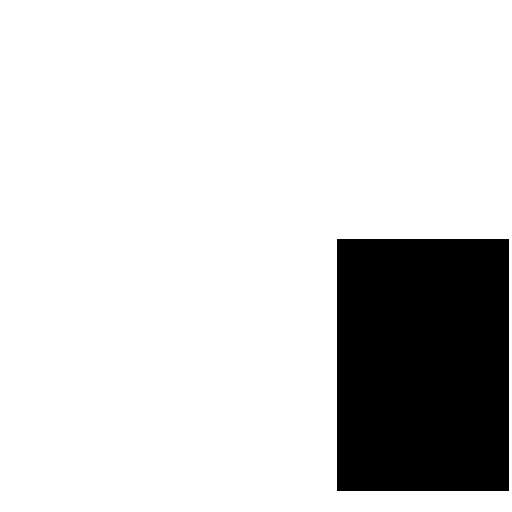

In [29]:
cropped = mask.crop((0, 0, 512, 512))
cropped.save("mask.png")
cropped.show()

# cropped + mask된 이미지를 다시 stable diffusion 또는 bedrock 으로..